<a href="https://colab.research.google.com/github/Geek-a-Byte/Federated-Learning-Aided-Cervical-Cancer-Classification/blob/main/FL_practise_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://learnopencv.com/federated-learning-using-pytorch-and-pysyft/

## Imports and Hook

In [ ]:
!pip uninstall syft
!pip install syft==0.2.9

In [ ]:
!pip install torchvision
!pip install torch

In [ ]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall Pillow
# install the new one
!pip install Pillow==5.3.0

In [1]:
# Imports here
import cv2
import shutil 
import os
import time
from collections import OrderedDict
from datetime import datetime
from pytz import timezone  
import copy

import torch
torch.cuda.empty_cache()

import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

We import PyTorch and PySyft, however we hook torch with syft with TorchHook function. TheTorchHook does the wrapping by adding all the additional functionality to PyTorch for doing Federated Learning and other Private AI techniques.

A Hook which overrides methods on PyTorch Tensors. The purpose of this class is to extend torch methods to allow for the moving of tensors from one worker to another and override torch methods to execute commands on one worker that are called on tensors controlled by the local worker.

This class is typically the first thing you will initialize when using PySyft with PyTorch because it is responsible for augmenting PyTorch with PySyft’s added functionality (such as remote execution).

In [2]:
import torch
import syft as sy
hook = sy.TorchHook(torch) # add extra functionality to PyTorch

## Creating a Virtual Worker


Let me show you what I mean by a pointer to tensor. First, let’s create a virtual machine owned by some health clinic, say harmony_clinic. We will be using this to simulate a machine present at a remote location. A thing to note is that syft calls these machines as VirtualWorker.

In [3]:
# create a machine owned by harmony clinic
harmony_clinic = sy.VirtualWorker(hook=hook,id='clinic')

## Sending the Tensors

Now we know that the harmony_clinic is at a remote location but it doesn’t have any data we can use. Let’s create some data so that we can send it to harmony_clinic.

In [4]:
# we create a Tensor, maybe this is some gene sequence
dna = torch.tensor([0,1,2,1,2])

# and now I send it, and in turn we get a pointer back that
# points to that Tensor
dna_ptr = dna.send(harmony_clinic)

print(dna_ptr)

(Wrapper)>[PointerTensor | me:73696300333 -> clinic:94988041952]


We see that the PointerTensor points from me (which is us, PySyft creates this me worker automatically) to harmony_clinic. We also see some random numbers, these are actually object IDs that PySyft assigns to every object.

Now harmony_clinic has the tensor that we sent. We can use harmony_clinic._objects to see objects that harmony_cliniccurrently has.

In [5]:
print(harmony_clinic._objects)


{94988041952: tensor([0, 1, 2, 1, 2])}


Notice the object ID for the tensor dna. It is same as above in dna_ptr.

## Getting back the Tensors

And in the same way, we can get a tensor back from a remote location by using the .get() function.

In [6]:
# get back dna
dna = dna_ptr.get()
print(dna)

# And as you can see... clinic no longer has the tensor dna anymore!!! It has moved back to our machine!
print(harmony_clinic._objects)

tensor([0, 1, 2, 1, 2])
{}


But that’s not machine learning, you might be wondering. I agree but now comes the fun part, we can use pointers to do arithmetic as we do in PyTorch. You will know what I mean in the following section.

## Doing Deep Learning with Pointer Tensors

In [7]:
a = torch.tensor([3.14, 6.28]).send(harmony_clinic)
b = torch.tensor([6.14, 3.28]).send(harmony_clinic)
c = a + b
print(c)

(Wrapper)>[PointerTensor | me:56777206489 -> clinic:95226575702]


Something very interesting happened behind the scenes, i.e. when did c = a + b on our machine, a command was sent to the remote machine that did that exact calculation, created a new tensor on its machine and then sent back a pointer to us which we now call c.

The amazing thing is this API has been extended to all the PyTorch operations including Back propogation. Hurray !!

This means that we can use the same PyTorch code that we usually do when doing Machine Learning.

In [8]:
  # we create two tensors and send it to bob
train = torch.tensor([2.4, 6.2], requires_grad=True).send(harmony_clinic)
label = torch.tensor([2, 6.]).send(harmony_clinic)

# we apply some function, in this case a rather simple one, just to show the idea, we use L1 loss
loss = (train-label).abs().sum()

# Yes, even .backward() works when working with Pointers
loss.backward()

# now we retreive back the train tensor
train = train.get()

print(train)

# If everything went well, we will see gradients accumulated 
# in .grad attribute of train
print(train.grad)

tensor([2.4000, 6.2000], requires_grad=True)
tensor([1., 1.])


And we see that indeed !! So as you can see, the API is really quite flexible and capable of performing nearly any operation you would normally perform in Torch on remote data. This lays the groundwork for the next part of this article i.e. doing federated learning on MNIST data.



Now that we have gone through the introduction of the API, we can now move onto the interesting part. Next, I will discuss training of the model.

## Real Life example on Federated Learning

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import logging

# import Pysyft to help us to simulate federated leraning
import syft as sy

# hook PyTorch to PySyft i.e. add extra functionalities to support Federated Learning
# and other private AI tools
hook = sy.TorchHook(torch) 

# we create two imaginary schools
westside_school = sy.VirtualWorker(hook, id="westside")
grapevine_high = sy.VirtualWorker(hook, id="grapevine")

Now we define hyper-parameters such as learning rate, batch size, test batch size etc.

In [10]:
# define the args
args = {
    'use_cuda' : True,
    'batch_size' : 64,
    'test_batch_size' : 1000,
    'lr' : 0.01,
    'log_interval' : 10,
    'epochs' : 10
}

# check to use GPU or not
use_cuda = args['use_cuda'] and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

Now we define a very simple CNN.

In [11]:
# create a simple CNN net
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels = 64, kernel_size = 3, stride = 1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=64*12*12, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10),
        )

        self.dropout = nn.Dropout2d(0.25)
    
    def forward(self, x):
        x = self.conv(x)
        x = F.max_pool2d(x,2)
        x = x.view(-1, 64*12*12)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

## Sending the data to schools

We load the data first and then transform the data into a federated dataset using .federate() method. It does a couple of things for us:

It splits the dataset in two parts (which was also done by the torch Data Loader as well)
But the extra thing it does is it also sends this data across two remote workers, in our case the two schools.
We will then used this newly created federated dataset to iterate over remote batches during our training loop.

One thing to note is that in real life we won’t be sending the data to schools, instead the schools will already have the data and we will just have pointer to their data. Here we are just simulating a real life scenario.

The test dataset will be with us only (i.e. the local worker in PySyft’s terminlogy), so the code is same as the official guide.



In [12]:
# Now we take the help of PySyft's awesome API to prepare the data for us and
# distribute for us across 2 workers ie. two schools
# normally we dont have to distribute data, data is already there at the site.
# We are doing this just to simulate federated learning.
# Below code looks just like torch code with just some minor changes. This is what's nice about PySyft.
federated_train_loader = sy.FederatedDataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    .federate((grapevine_high, westside_school)),
    batch_size=args['batch_size'], shuffle=True)

# test data remains with us locally
# this is the normal torch code to load test data from MNIST
# that we are all familiar with
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args['test_batch_size'], shuffle=True)

0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


## Training and Validation functions

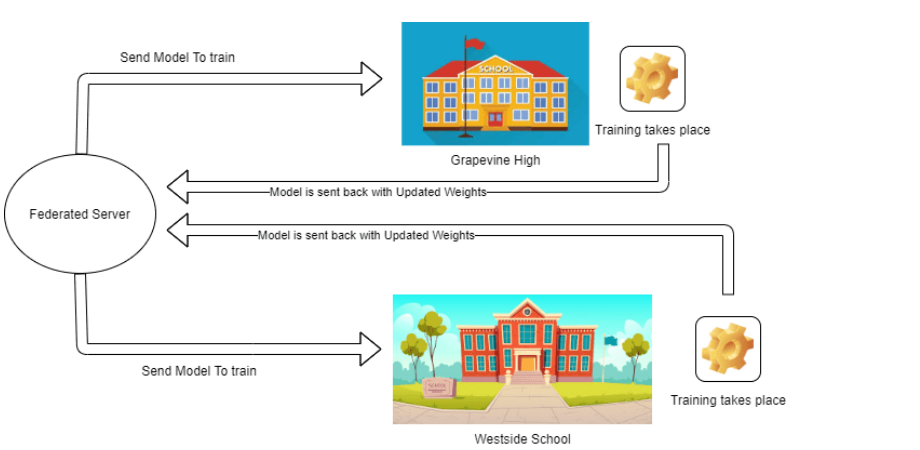

Now each time we train the model, we need to send it to the right location for each batch. We used .send() function that we learnt above to do this.

Then, we perform all the operations remotely with the same syntax like we’re doing local PyTorch. When we’re done, we get back the updated model using the .get() method. Simple isn’t it ?

Note in the below train function that (data, target) is a pair of PointerTensor.
In a PointerTensor, we can get the worker it points to using the .location attribute, and that is what precisely we are using to send the model to the correct location.

In [13]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()

    # iterate over federated data
    for batch_idx, (data, target) in enumerate(train_loader):

        # send the model to the remote location 
        model = model.send(data.location)

        # the same torch code that we are use to
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        # this loss is a ptr to the tensor loss 
        # at the remote location
        loss = F.nll_loss(output, target)

        # call backward() on the loss ptr,
        # that will send the command to call
        # backward on the actual loss tensor
        # present on the remote machine
        loss.backward()

        optimizer.step()

        # get back the updated model
        model.get()

        if batch_idx % args['log_interval'] == 0:

            # a thing to note is the variable loss was
            # also created at remote worker, so we need to
            # explicitly get it back
            loss = loss.get()

            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, 
                    batch_idx * args['batch_size'], # no of images done
                    len(train_loader) * args['batch_size'], # total images left
                    100. * batch_idx / len(train_loader), 
                    loss.item()
                )
            )

The test function remains the same as it is run locally on our machine only whereas training happens remotely.

In [14]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # add losses together
            test_loss += F.nll_loss(output, target, reduction='sum').item() 

            # get the index of the max probability class
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

We can now start training the model at last and the best part is, we use the same code when we train the model locally.

In [15]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args['lr'])

logging.info("Starting training !!")

for epoch in range(1, args['epochs'] + 1):
        train(args, model, device, federated_train_loader, optimizer, epoch)
        test(model, device, test_loader)
    
# thats all we need to do XD

Train Epoch: 1 [0/60032 (0%)]	Loss: 2.296196
Train Epoch: 1 [640/60032 (1%)]	Loss: 2.219435
Train Epoch: 1 [1280/60032 (2%)]	Loss: 2.031152
Train Epoch: 1 [1920/60032 (3%)]	Loss: 1.925716
Train Epoch: 1 [2560/60032 (4%)]	Loss: 1.516023
Train Epoch: 1 [3200/60032 (5%)]	Loss: 1.161142
Train Epoch: 1 [3840/60032 (6%)]	Loss: 0.826113
Train Epoch: 1 [4480/60032 (7%)]	Loss: 0.644923
Train Epoch: 1 [5120/60032 (9%)]	Loss: 0.753165
Train Epoch: 1 [5760/60032 (10%)]	Loss: 0.477175
Train Epoch: 1 [6400/60032 (11%)]	Loss: 0.680291
Train Epoch: 1 [7040/60032 (12%)]	Loss: 0.691731
Train Epoch: 1 [7680/60032 (13%)]	Loss: 0.610803
Train Epoch: 1 [8320/60032 (14%)]	Loss: 0.316480
Train Epoch: 1 [8960/60032 (15%)]	Loss: 0.458795
Train Epoch: 1 [9600/60032 (16%)]	Loss: 0.297134
Train Epoch: 1 [10240/60032 (17%)]	Loss: 0.339250
Train Epoch: 1 [10880/60032 (18%)]	Loss: 0.626656
Train Epoch: 1 [11520/60032 (19%)]	Loss: 0.513018
Train Epoch: 1 [12160/60032 (20%)]	Loss: 0.313240
Train Epoch: 1 [12800/60032 (

KeyboardInterrupt: ignored

## Conclusion

Using the exact same code as above, I was able to get accuracy of 98% which is quite good.

We were able to do all the training without even seeing the data present at those two remote locations and also without risking their privacy. So now both the schools can use this model to classify handwritten digits and everyone is happy.

That sums up the federated learning part.

If you made it this far, pat yourself on the back. I know that’s all quite a lot to take. So I will summarise everything we did for you guys.

- We learned the importance of federated learning, how is it different from the normal centralised machine learning approach.
- We learned all the basic details about PySyt’s API including working with tensors present on remote location using Pointer Tensors. We also saw that we can do normal PyTorch Tensor stuff using Pointer Tensor as well.
- Then we simulated a real life scenario where we created two imaginary schools that had the data with them and we used federated learning to combine the power of their data to create an effective model.
- We trained a model and hardly had to change the official PyTorch example on MNIST to a real Federated Learning scenario.

A thing to note is that this is a very basic federated learning scenario. There a lot of flaws still in this setup for example:

- We can learn information about the data present at remote location by looking at the change in the gradients of our model. A common way to remedy this is to use a Secure Aggregator that receives models from all the remote locations and takes their mean and only then sends back the aggregated model to us.
- Since we spent a lot of time building our model, we don’t want anyone at the remote location to see it. Right now, when we send our model to remote location, it is completely exposed.
- Right now the training is happening linearly i.e one worker after the another, this is causing bottlenecks in performance. What we want is to train this model in parallel across all workers since the training of the model on each worker is independent of each other.
- We could use differential privacy, where we inject some noise in the data at the remote location thereby making the training more secure.